## Load data

In [1]:
import sys
sys.path.append('../')
from utilities import *

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime


In [4]:
# Define the database folder path and file names
db_folder = '../../data/processed_data/yelp_data/'
data_files = ['business', 'categories', 'review', 'user']

# Load data into a dictionary
yelp_data = load_data_from_db(db_folder, data_files)

# Check loaded data
for table, df in yelp_data.items():
    print(f"Loaded {len(df)} rows from {table} table.")

Loaded 78059 rows from business table.
Loaded 360656 rows from categories table.
Loaded 980418 rows from review table.
Loaded 229447 rows from user table.


In [5]:
df_business = yelp_data["business"]
df_review = yelp_data["review"]
df_user = yelp_data["user"]

## Data sparity

In [20]:
# 1. Review Distribution (Users)
def analyze_user_reviews(df_review, k=5):
    # Count reviews per user
    user_review_counts = df_review.groupby('user_id').size()
    
    # Calculate percentage of users with fewer than k reviews
    users_below_k = (user_review_counts < k).sum()
    total_users = len(user_review_counts)
    percentage = (users_below_k / total_users) * 100
    
    print(f"Percentage of users with fewer than {k} reviews: {percentage:.2f}%")
    
    # Set Seaborn style for improved aesthetics
    sns.set_style("whitegrid")  # Adds a grid for better readability
    
    # Create figure
    plt.figure(figsize=(10, 6))
    
    # Plot histogram using Seaborn
    g = sns.histplot(data=user_review_counts, bins=50)
    g.set_yscale('log')  # Set y-axis to log scale for better visualization of skewed data
    # Customize the plot
    plt.xlim(0, 600)  # Limit x-axis to 600
    plt.axvline(x=k, color='red', linestyle='--', label=f'{k} reviews')  # Add vertical line
    plt.title('Distribution of Reviews per User', fontsize=14, pad=10)
    plt.xlabel('Number of Reviews', fontsize=12)
    plt.ylabel('Number of Users (log scale)', fontsize=12)
    plt.legend()
    
    # Display the plot
    plt.show()

# 2. Review Distribution (Businesses)
def analyze_business_reviews(df_business, k=5):
    # Use review_count from df_business
    business_review_counts = df_business['review_count']
    
    # Calculate percentage of businesses with fewer than k reviews
    businesses_below_k = (business_review_counts < k).sum()
    total_businesses = len(business_review_counts)
    percentage = (businesses_below_k / total_businesses) * 100
    
    print(f"Percentage of businesses with fewer than {k} reviews: {percentage:.2f}%")
    
    # Set Seaborn style
    sns.set_style("whitegrid")
    
    # Create figure
    plt.figure(figsize=(10, 6))
    
    # Plot histogram using Seaborn
    g = sns.histplot(data=business_review_counts, bins=50)
    g.set_yscale('log')
    # Customize the plot
    plt.xlim(0, 6000)
    plt.axvline(x=k, color='red', linestyle='--', label=f'{k} reviews')
    plt.title('Distribution of Reviews per Business', fontsize=14, pad=10)
    plt.xlabel('Number of Reviews', fontsize=12)
    plt.ylabel('Number of Businesses (log scale)', fontsize=12)
    plt.legend()
    
    # Display the plot
    plt.show()

# 3. Matrix Sparsity
def calculate_sparsity(df_review):
    # Get unique users and businesses
    n_users = df_review['user_id'].nunique()
    n_businesses = df_review['business_id'].nunique()
    
    # Actual interactions (reviews)
    n_reviews = len(df_review)
    
    # Total possible interactions
    total_possible = n_users * n_businesses
    
    # Sparsity ratio
    sparsity = 1 - (n_reviews / total_possible)
    density = n_reviews / total_possible
    
    print(f"Matrix Sparsity: {sparsity:.4f}")
    print(f"Matrix Density: {density:.4f}")
    print(f"Actual interactions: {n_reviews}")
    print(f"Possible interactions: {total_possible}")

# 4. Temporal Perspective
def analyze_temporal(df_review, df_business):
    # Convert date to datetime and extract year
    df_review['year'] = pd.to_datetime(df_review['date']).dt.year
    
    # Count reviews per year
    reviews_per_year = df_review.groupby('year').size()
    
    # Get first review year per user and business
    user_first_review = df_review.groupby('user_id')['year'].min()
    business_first_review = df_review.groupby('business_id')['year'].min()
    
    # Count new users and businesses per year
    new_users_per_year = user_first_review.value_counts().sort_index()
    new_businesses_per_year = business_first_review.value_counts().sort_index()
    
    # Set Seaborn style
    sns.set_style("whitegrid")
    
    # Create figure
    plt.figure(figsize=(12, 6))
    
    # Prepare data for Seaborn (convert to DataFrame for lineplot)
    data = pd.DataFrame({
        'Year': reviews_per_year.index,
        'New Reviews': reviews_per_year.values,
        'New Users': new_users_per_year.reindex(reviews_per_year.index, fill_value=0).values,
        'New Businesses': new_businesses_per_year.reindex(reviews_per_year.index, fill_value=0).values
    })
    
    # Plot using Seaborn
    sns.lineplot(x='Year', y='New Reviews', data=data, label='New Reviews', color='blue')
    sns.lineplot(x='Year', y='New Users', data=data, label='New Users', color='green')
    sns.lineplot(x='Year', y='New Businesses', data=data, label='New Businesses', color='orange')
    
    # Customize the plot
    plt.ylim(0, 120000)  # Set y-axis limit
    plt.title('Temporal Growth Analysis', fontsize=14, pad=10)
    plt.xticks(data['Year'], rotation=35)
    plt.xlabel('Year', fontsize=12)
    plt.ylabel('Count', fontsize=12)
    
    # Format x-axis as "Jan YYYY"
    plt.gca().xaxis.set_major_formatter(lambda x, pos: f"Jan {int(x)}" if x == int(x) else "")
    plt.gca().tick_params(axis='x', rotation=45)  # Rotate labels for readability
    
    plt.legend()
    
    # Display the plot
    plt.show()



## Cold start

In [34]:
df_user = df_user[['user_id', 'yelping_since']]

In [40]:
# find the latest date in yelp_since in df_user
latest_yelping_since = df_user['yelping_since'].max()
latest_yelping_since

Timestamp('2022-01-19 17:15:36')

In [64]:
# Add year column to df_review if not already present
df_review['date'] = pd.to_datetime(df_review['date'])
df_review['year'] = df_review['date'].dt.year

df_user['yelping_since'] = pd.to_datetime(df_user['yelping_since'])

current_date = pd.to_datetime('2022-01-31')  # Using current date as reference

C:\Users\cathy\AppData\Local\Temp\ipykernel_27580\3199527528.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_user['yelping_since'] = pd.to_datetime(df_user['yelping_since'])


In [194]:
# 1. Proportion of New Users / Businesses
def analyze_new_entities(df_review, timeframe='year'):
    # Get first appearance of users and businesses
    user_first = df_review.groupby('user_id')['date'].min()
    business_first = df_review.groupby('business_id')['date'].min()
    
    # Aggregate by timeframe (year only for simplicity as per your code)
    new_users = user_first.dt.year.value_counts().sort_index()
    new_businesses = business_first.dt.year.value_counts().sort_index()
    time_label = 'Year'
    index = new_users.index
    
    # Prepare data for Seaborn
    data = pd.DataFrame({
        time_label: index,
        'New Users': new_users.reindex(index, fill_value=0).values,
        'New Businesses': new_businesses.reindex(index, fill_value=0).values
    })
    
    # Set Seaborn style
    sns.set_style("whitegrid")
    
    # Create figure
    plt.figure(figsize=(12, 6))
    
    # Plot using Seaborn
    sns.lineplot(x=time_label, y='New Users', data=data, label='New Users', color='blue', linewidth=2.5)
    sns.lineplot(x=time_label, y='New Businesses', data=data, label='New Businesses', color='green', linewidth=2.5)
    
    # Customize the plot
    plt.ylim(0, 20000)  # Set y-axis limit
    plt.title(f'Number of New Users and Businesses per {timeframe.capitalize()}', fontsize=14, pad=10)
    plt.xlabel(time_label, fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.xticks(data['Year'], rotation=35)  # Retain your custom rotation
    plt.gca().xaxis.set_major_formatter(lambda x, pos: f"Jan {int(x)}" if x == int(x) else "")
    plt.legend(fontsize=10)
    
    # Display the plot
    plt.show()

# 2. Time to First Review
def time_to_first_review(df_review, df_user):  
    # Get the first review date for each user
    first_reviews = df_review.groupby('user_id')['date'].min().reset_index()
    
    # Merge with user join dates
    user_data = pd.merge(first_reviews, df_user[['user_id', 'yelping_since']], 
                         on='user_id', how='inner')
    
    # Calculate time to first review in days
    time_diffs = (user_data['date'] - user_data['yelping_since']).dt.days
    
    # Remove negative differences and handle missing values
    time_diffs = time_diffs[time_diffs >= 0].dropna()
    
    # Summary statistics
    mean_time = time_diffs.mean()
    median_time = time_diffs.median()
    stats_text = (
        f"Average time to first review: {mean_time:.2f} days\n"
        f"Median time to first review: {median_time:.2f} days\n"
        f"Number of users: {len(time_diffs)}"
    )
    
    # Set Seaborn style
    sns.set_style("whitegrid")
    
    # Create figure
    plt.figure(figsize=(10, 6))
    
    # Plot histogram using Seaborn
    sns.histplot(data=time_diffs, bins=50)
    
    # Customize the plot
    plt.title('Time to First Review for Users', fontsize=14, pad=10)
    plt.xlabel('Days to First Review', fontsize=12)
    plt.ylabel('Number of Users (log scale)', fontsize=12)
    
    # Add text box with statistics
    plt.text(0.95, 0.95, stats_text, transform=plt.gca().transAxes, 
             fontsize=10, verticalalignment='top', horizontalalignment='right', 
             bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.8))
    
    # Display the plot
    plt.yscale('log')
    plt.show()

# 3. User Tenure vs. Number of Reviews
def user_tenure_reviews(df_review, df_user, months=12):
    # Calculate cutoff date for new users
    cutoff_date = current_date - pd.Timedelta(days=months * 30)
    
    # Filter users who joined in the last N months
    new_users = df_user[df_user['yelping_since'] >= cutoff_date]['user_id']
    total_new_users = len(new_users)
    
    # Get review activity for these new users
    new_user_reviews = df_review[df_review['user_id'].isin(new_users)]
    
    # Count reviews per new user
    reviews_per_user = new_user_reviews.groupby('user_id').size()
    active_users = len(reviews_per_user)
    
    # Calculate percentage of active users
    percentage_active = (active_users / total_new_users * 100) if total_new_users > 0 else 0
    
    stats_text = (
        f"Users joined in last {months} months: {total_new_users}\n"
        f"Users with at least 1 review: {active_users}\n"
        f"Percentage active: {percentage_active:.2f}%"
    )
    
    # Set Seaborn style
    sns.set_style("whitegrid")
    
    # Create figure
    plt.figure(figsize=(10, 6))
    
    if not reviews_per_user.empty:
        # Plot histogram using Seaborn
        sns.histplot(data=reviews_per_user, bins=50)
        
        # Customize the plot
        plt.title(f'Review Distribution for Users (Last {months} Months)', fontsize=14, pad=10)
        plt.xlabel('Number of Reviews', fontsize=12)
        plt.ylabel('Number of Users (log scale)', fontsize=12)
        
        # Add text box with statistics
        plt.text(0.55, 0.8, stats_text, transform=plt.gca().transAxes, 
                 fontsize=12, verticalalignment='top', horizontalalignment='left', 
                 bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.8))
    else:
        plt.text(0.5, 0.5, 'No reviews found for new users', 
                 horizontalalignment='center', verticalalignment='center', fontsize=12)
        plt.title(f'Review Distribution for Users (Last {months} Months)', fontsize=14, pad=10)
    
    # Display the plot
    plt.yscale('log')
    plt.show()


# 4. Exposure of New Businesses
def business_exposure(df_review, df_business, years_new = 0.5, years_old = 10):
    business_first = df_review.groupby('business_id')['date'].min()
    business_age = (current_date - business_first).dt.days / 365

    df_business['business_since'] = df_business['business_id'].map(business_first)
    df_business['business_age'] = (current_date - df_business['business_since']).dt.days / 365
    business_data = df_business[['business_id', 'business_since', 'business_age', 'review_count']]

    business_data = business_data.dropna()
    
    # Split into new and old businesses
    new_businesses = business_data[business_data['business_age'] <= years_new]
    old_businesses = business_data[business_data['business_age'] > years_old]

    # Calculate average review counts
    new_avg_reviews = new_businesses['review_count'].mean()
    old_avg_reviews = old_businesses['review_count'].mean()

    stats_text = (f"Average reviews for businesses ≤ {years_new} year: {new_avg_reviews:.2f}\n"
    f"Average reviews for businesses > {years_old} year: {old_avg_reviews:.2f}")
    
    # Plot
    sns.set_style("whitegrid")
    plt.figure(figsize=(10, 6))
    plt.boxplot([new_businesses['review_count'], old_businesses['review_count']], 
                labels=['New Businesses', 'Established Businesses'])
    plt.title('Review Count Distribution by Business Age')
    plt.ylabel('Number of Reviews')
    plt.yscale('log')  # Log scale for better visibility
    plt.text(0.95, 0.95, stats_text, transform=plt.gca().transAxes, 
             fontsize=10, verticalalignment='top', horizontalalignment='right', 
             bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.8))
    plt.show()
    

In [101]:
p25 = business_age.quantile(0.25)
p75 = business_age.quantile(0.75)
business_age.min(), business_age.max(), business_age.mean(), business_age.median(), p25, p75

(np.float64(0.030136986301369864),
 np.float64(16.926027397260274),
 np.float64(7.778614281262092),
 np.float64(7.76986301369863),
 np.float64(4.928767123287671),
 np.float64(10.597260273972603))

## Long-Tail

In [190]:
from scipy.stats import skew

# Calculate the first review date for each business
business_first = df_review.groupby('business_id')['date'].min()

# Map first review dates and calculate business age
df_business['business_since'] = df_business['business_id'].map(business_first)
df_business['business_age'] = (current_date - df_business['business_since']).dt.days / 365
business_data = df_business[['business_id', 'business_since', 'business_age', 'review_count']].dropna()

# Review counts for all businesses (for long-tail analysis)
review_counts = business_data['review_count'].sort_values(ascending=False)
total_reviews = review_counts.sum()
    
    
# 1. Pareto Distribution Analysis
def pareto (review_counts):
    total_reviews = review_counts.sum()
    cumulative_reviews = review_counts.cumsum() / total_reviews
    top_20_percent = int(len(review_counts) * 0.2)  # Top 20% of businesses
    pareto_value = cumulative_reviews.iloc[top_20_percent] * 100
    print(f"Top 20% of businesses receive {pareto_value:.2f}% of total reviews")

    plt.figure(figsize=(10, 6))
    sns.lineplot(x=range(len(cumulative_reviews)), y=cumulative_reviews * 100, color='blue', linewidth=2.5)
    plt.axvline(x=top_20_percent, color='red', linestyle='--', label=f'Top 20% ({pareto_value:.2f}%)')
    plt.title('Pareto Distribution of Reviews Across Businesses', fontsize=14, pad=10)
    plt.xlabel('Number of Businesses (Ranked by Review Count)', fontsize=12)
    plt.ylabel('Cumulative Percentage of Reviews', fontsize=12)
    plt.legend(fontsize=10)
    plt.show()

# 2. Skewness and Gini Coefficient
def skewness(review_counts):
    total_reviews = review_counts.sum()
    cumulative_reviews = review_counts.cumsum() / total_reviews
    skewness = skew(review_counts)
    gini = 2 * (cumulative_reviews - np.linspace(0, 1, len(cumulative_reviews))).mean()
    print(f"Skewness of review distribution: {skewness:.2f}")
    print(f"Gini Coefficient of review distribution: {gini:.2f}")

# 3. Cumulative Distribution Plot (CDF)
def cumulative_distribution(review_counts):
    plt.figure(figsize=(10, 6))
    sns.ecdfplot(data=review_counts, color='blue', linewidth=2.5)
    plt.title('Cumulative Distribution of Reviews per Business', fontsize=14, pad=10)
    plt.xlabel('Number of Reviews', fontsize=12)
    plt.ylabel('Proportion of Businesses', fontsize=12)
    plt.xscale('log')  # Log scale to emphasize the long tail
    plt.show()



## Result

Percentage of users with fewer than 5 reviews: 70.65%


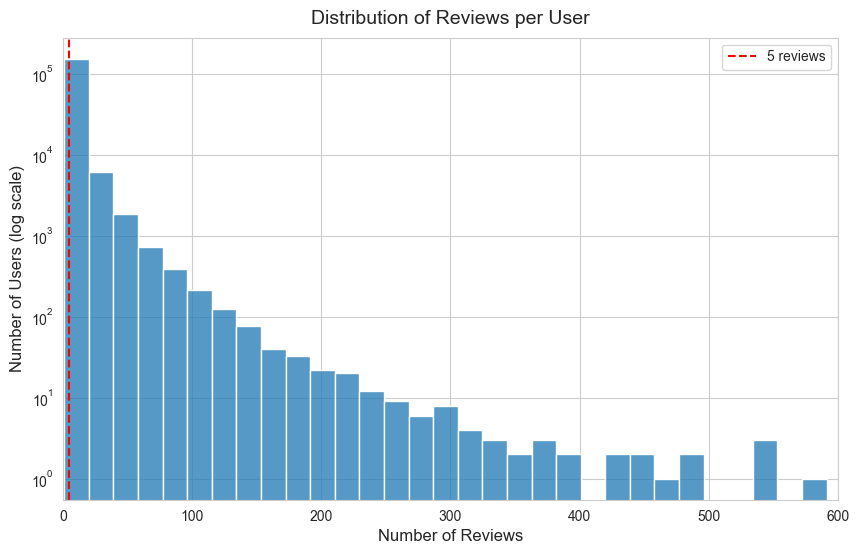

Percentage of businesses with fewer than 5 reviews: 0.00%


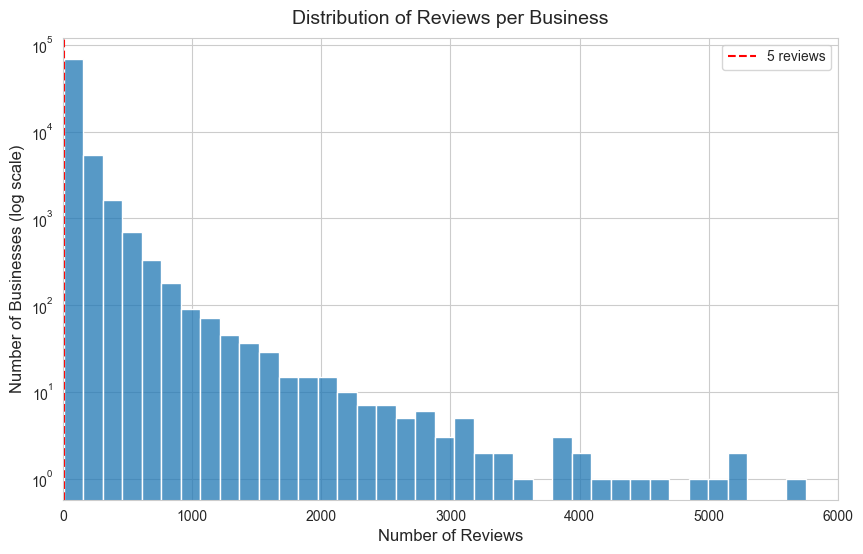

Matrix Sparsity: 0.9999
Matrix Density: 0.0001
Actual interactions: 980418
Possible interactions: 11790436855


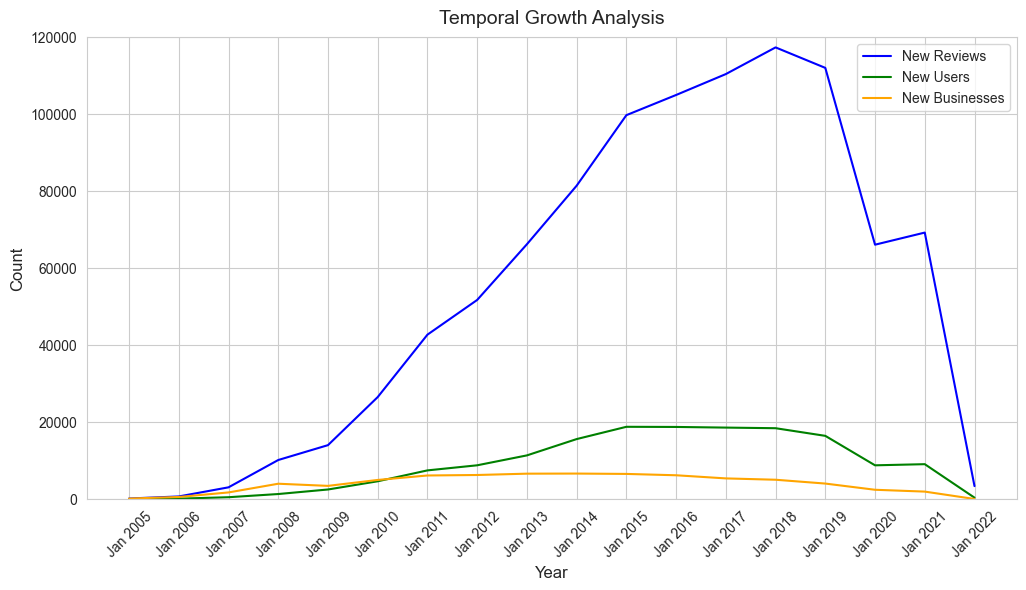

In [192]:
# data sparity
analyze_user_reviews(df_review)
analyze_business_reviews(df_business)
calculate_sparsity(df_review)
analyze_temporal(df_review, df_business)

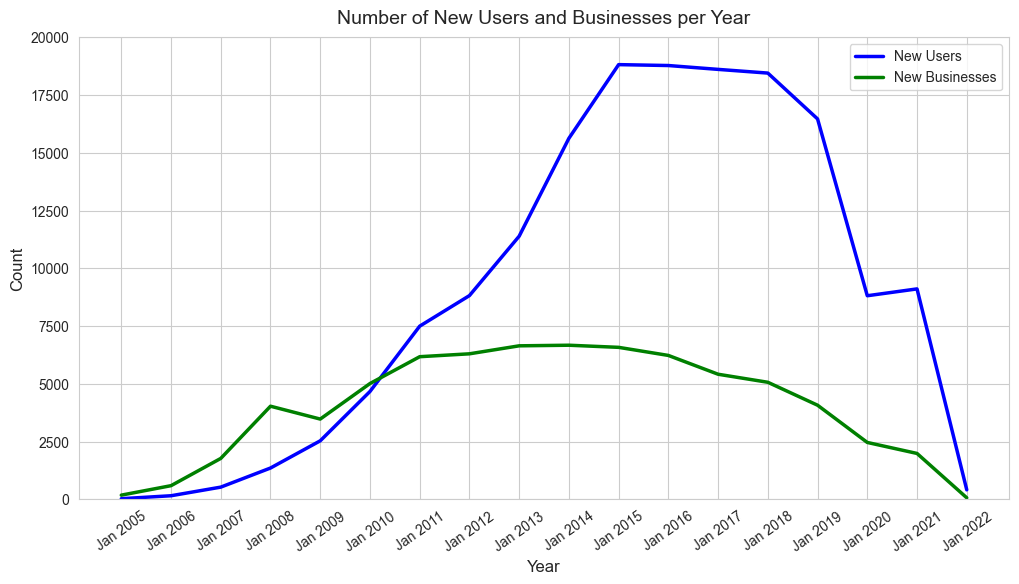

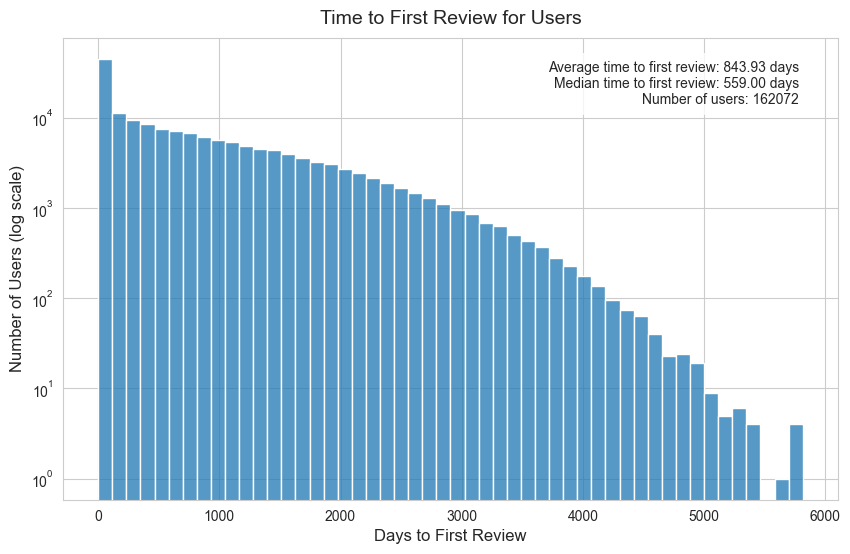

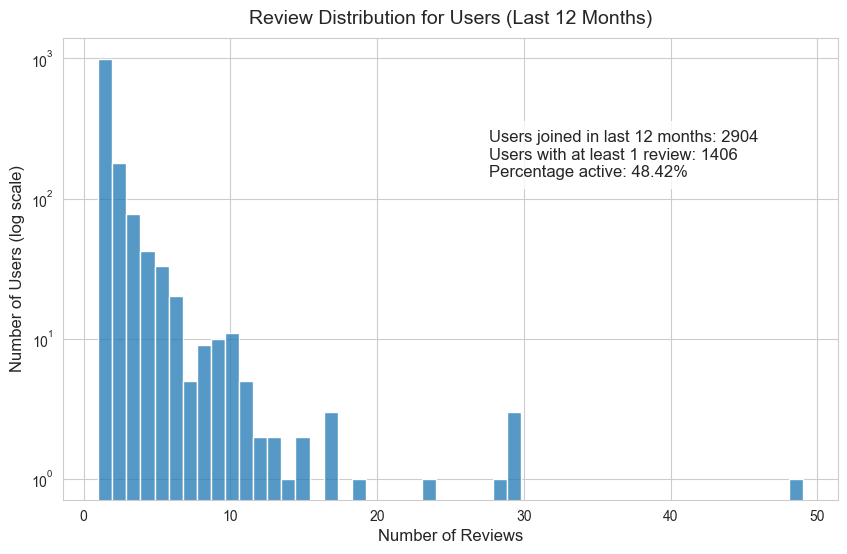

C:\Users\cathy\AppData\Local\Temp\ipykernel_27580\3382416296.py:168: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([new_businesses['review_count'], old_businesses['review_count']],


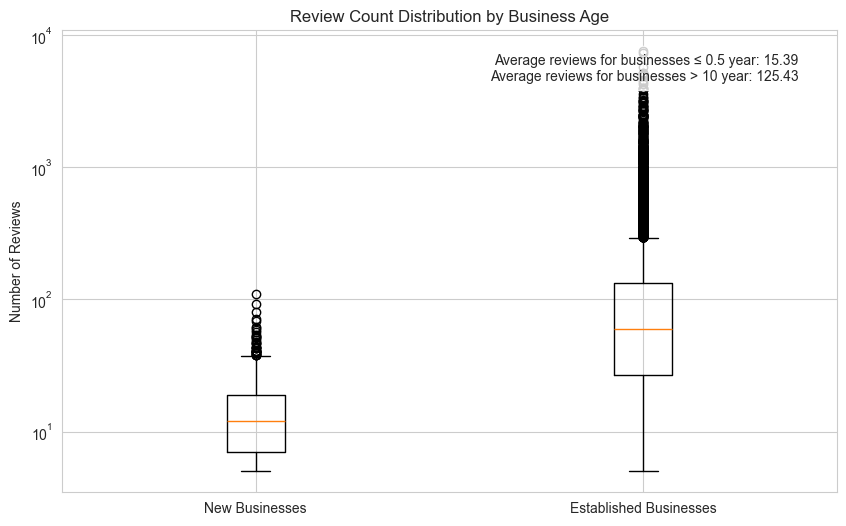

In [195]:
# Cold Start
analyze_new_entities(df_review, timeframe='year')
time_to_first_review(df_review, df_user)
user_tenure_reviews(df_review, df_user, months=12)
business_exposure(df_review, df_business)

Top 20% of businesses receive 67.15% of total reviews


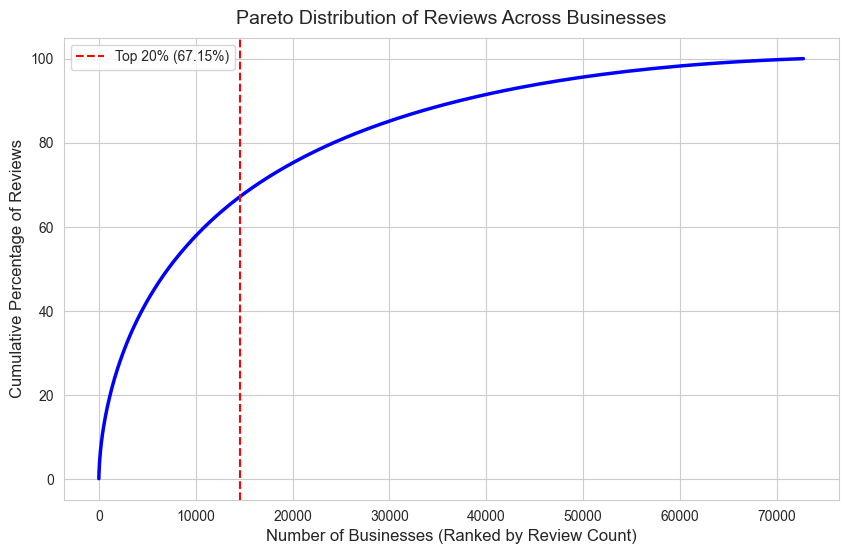

Skewness of review distribution: 12.15
Gini Coefficient of review distribution: 0.63


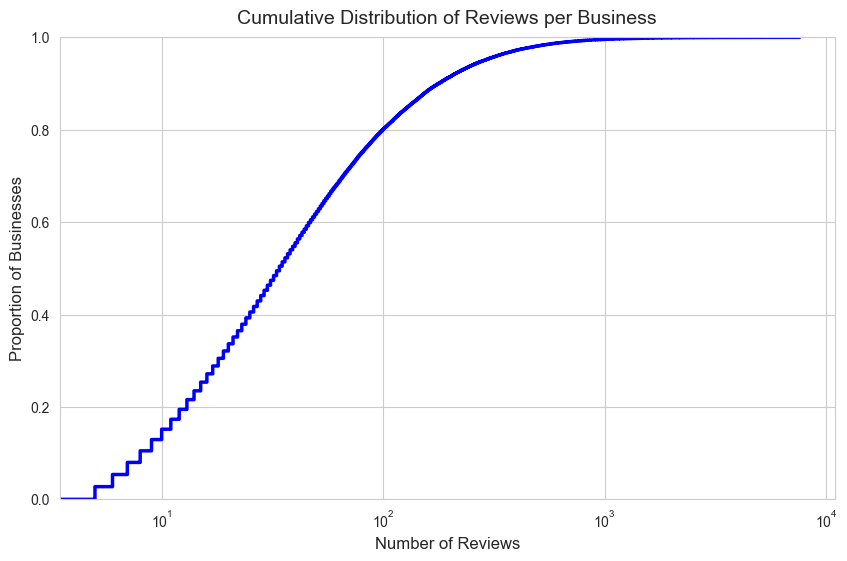

In [196]:
# Long tail
pareto(review_counts)
skewness(review_counts)
cumulative_distribution(review_counts)